In [1]:
import pandas as pd
import numpy as np
import os

import data
from common import OUTPUTPATH
from modules.experiments import KFold, GroupKFoldSpecial
STATE = np.random.RandomState(seed=1000)

In [2]:
interpolation = pd.read_csv(os.path.join(OUTPUTPATH, 'interpolation.csv'))
interpolation = interpolation.set_index('Unnamed: 0')
interpolation.index.name = None
interpolation


,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
Lr_pcc,0.202688,0.010509,0.215175,0.055519,0.556380,0.043451,0.588246,0.146107,2.251545,0.100844,2.359290,0.414337
GAM_pcc,0.017693,0.003309,0.074912,0.032162,0.059179,0.011989,0.228333,0.092471,0.403941,0.040225,1.093641,0.498897
RuFit_pcc,0.004879,0.002435,0.069781,0.028317,0.015262,0.008016,0.216404,0.078707,0.157948,0.045570,1.252573,0.628597
RF_pcc,0.000015,0.000080,0.065461,0.026606,0.000058,0.000319,0.199298,0.067024,0.243237,0.003150,1.069053,0.685669


In [3]:
extrapolation = pd.read_csv(os.path.join(OUTPUTPATH, 'extrapolation.csv'))
extrapolation = extrapolation.set_index('Unnamed: 0')
extrapolation.index.name = None
extrapolation

,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
Lr_pcc,0.204733,0.011155,0.182432,0.134576,0.567365,0.041419,0.616143,0.435963,2.277663,0.099304,2.644404,1.741969
GAM_pcc,0.019174,0.002590,0.154716,0.183469,0.065718,0.009194,0.377425,0.415537,0.414240,0.035148,2.538467,3.494145
RuFit_pcc,0.005574,0.002911,0.135766,0.189940,0.018276,0.010117,0.311302,0.410696,0.168864,0.063884,2.922825,4.432923
RF_pcc,0.000305,0.000477,0.108071,0.178174,0.000609,0.000953,0.246090,0.382492,0.238811,0.003490,1.564812,1.846939


In [4]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)

In [20]:
def get_full_loss(_train, _test):
    """This is calculate realistic full phase error
    """
    train_uniq, train_cnt = np.unique(data.y[data.y.index.isin(_train)].values, return_counts=True, axis=0)
    _select = train_uniq[list(train_cnt).index(max(train_cnt))]
    
    test_uniq, test_cnt = np.unique(data.y[data.y.index.isin(_test)], return_counts=True, axis=0)
    acc_cnt = 0
    for i in range(len(test_uniq)):
        if (test_uniq[i] == _select).all():
            acc_cnt += test_cnt[i]
    return 1-acc_cnt/sum(test_cnt)

def get_hamming_loss(_train, _test, name):
    """This is calculate realistic hamming loss
    """
    train_uniq, train_cnt = np.unique(data.y[name][data.y[name].index.isin(_train)].values, return_counts=True, axis=0)    
    test_uniq, test_cnt = np.unique(data.y[name][data.y[name].index.isin(_test)], return_counts=True, axis=0)
    _select = train_uniq[list(train_cnt).index(max(train_cnt))]

    acc_cnt = 0
    for i in range(len(test_uniq)):
        if test_uniq[i] == _select:
            acc_cnt += test_cnt[i]
    return 1-acc_cnt/sum(test_cnt)

Below is interpolation unreal and uniformed full phase loss

In [10]:
# interpolation full phase
uniq, cnts = np.unique(data.y.values, return_counts=True, axis=0)
unreal_inter_full_info_error = 1 - max(cnts)/sum(cnts)
inter_full_uninfo_error = 1 - (1/2)**4
print('Interpolation full sphase error base line:\nUnreal inform error:{} \nUninform error:{}'.format(unreal_inter_full_info_error, inter_full_uninfo_error))


Interpolation full sphase error base line:
Unreal inform error:0.5912162162162162 
Uninform error:0.9375


Below is interpolation unreal and uniformed hamming loss

In [11]:
# interpolation hamming loss
unreal_inter_hamming_loss = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    error = 1 - max(cnt)/sum(cnt)
    unreal_inter_hamming_loss.append(error)
unreal_inter_hamming_loss = np.mean(unreal_inter_hamming_loss)
inter_uninfo_hamming_loss = np.mean([0.5, 0.5, 0.5, 0.5])

print('Interpolation average sphases error base line:\nUnreal inform error:{} \nUninform error:{}'.format(unreal_inter_hamming_loss, inter_uninfo_hamming_loss))


Interpolation average sphases error base line:
Unreal inform error:0.27956081081081074 
Uninform error:0.5


Below is extrapolation unreal and uniformed full phase loss

In [26]:
# extrapolation full phase loss
unreal_extra_full_info_error = []
cnt =0
for train, test in GroupKFoldSpecial(len(set(data.comp_ids)), size=20).split(data.x1, data.y, data.comp_ids):
    unreal_extra_full_info_error.append(get_full_loss(train, test))
unreal_extra_full_info_error = np.mean(unreal_extra_full_info_error)
unreal_extra_full_info_error
print('Extrapolation full sphase error base line:\nUnreal inform error:{}'.format(unreal_extra_full_info_error))


Extrapolation full sphase error base line:
Unreal inform error:0.5233630952380952


Below is extrapolation unreal and uniformed hamming loss

In [60]:
# extrapolation hamming loss
unreal_extra_hamming_loss = []
for train, test in GroupKFoldSpecial(len(set(data.comp_ids)), size=20).split(data.x1, data.y, data.comp_ids):
    for each in [data.sphere, data.vesicle, data.worm, data.other]:
        unreal_extra_hamming_loss.append(get_hamming_loss(data.y.index.tolist(), test, each.name))
unreal_extra_hamming_loss = np.mean(unreal_extra_hamming_loss)
print('Interpolation average sphases error base line:\nUnreal inform error:{}'.format(unreal_extra_hamming_loss))

Interpolation average sphases error base line:
Unreal inform error:0.2485863095238095


Negative loglikelihood

In [30]:
import math

def neglikehood(p, y):
    result = (-math.log2(p)*y - (1-y)*math.log2(1-p))
    return (result)

def get_full_logs(_train, _test):
    train_uniq, train_cnt = np.unique(data.y[data.y.index.isin(_train)].values, return_counts=True, axis=0)
    train_uniq = [list(each) for each in train_uniq]
    train_prob = train_cnt/sum(train_cnt)
    
    test_uniq, test_cnt = np.unique(data.y[data.y.index.isin(_test)], return_counts=True, axis=0)
    test_uniq = [list(each) for each in test_uniq]
    logs = 0
    for i in range(len(test_uniq)):
        try:
            indx = train_uniq.index(test_uniq[i])
            logs += -1* test_cnt[i] * math.log2(train_prob[indx])
        except:
            pass
    return logs/sum(test_cnt)

def get_hamming_logs(_train, _test, name):
    train_uniq, train_cnt = np.unique(data.y[name][data.y[name].index.isin(_train)].values, return_counts=True, axis=0)
    train_uniq = train_uniq.tolist()
    train_prob = train_cnt/sum(train_cnt)
    
    test_uniq, test_cnt = np.unique(data.y[name][data.y[name].index.isin(_test)], return_counts=True, axis=0)
    test_uniq = test_uniq.tolist()
    
    logs = 0
    for i in range(len(test_uniq)):
        try:
            indx = train_uniq.index(test_uniq[i])
            logs += -1* test_cnt[i] * math.log2(train_prob[indx])
        except:
            pass
    return logs/sum(test_cnt)

In [46]:
# unrealistic interpolation
uniq, cnt = np.unique(data.y.values, axis=0, return_counts=True)
prob = cnt/sum(cnt)

unreal_inter_full_info_loss = 0
for each in cnt:
    unreal_inter_full_info_loss += -each * math.log2(each/sum(cnt))
unreal_inter_full_info_loss = unreal_inter_full_info_loss/sum(cnt)
print("Interpolation full phase logloss base line:\n Unreal Inform error: ", unreal_inter_full_info_loss)

Interpolation full phase logloss base line:
 Unreal Inform error:  2.5225679165070907


In [33]:
# interpolation average sphase informed
unreal_inter_avg_info_loss = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = max(cnt)/sum(cnt) if uniq[list(cnt).index(max(cnt))] else 1- max(cnt)/sum(cnt)
    
    for indx in range(len(each)):
        unreal_inter_avg_info_loss.append(neglikehood(prob, each[indx]))
unreal_inter_avg_info_loss = np.mean(unreal_inter_avg_info_loss)
print('Interpolation average morphology logloss base line:\nUnreal Inform logloss:{}'.format(unreal_inter_avg_info_loss))


Interpolation average sphase logloss base line:
Unreal Inform logloss:0.7401933665227551


In [47]:
real_extra_full_info_loss = []
for train, test in GroupKFoldSpecial(len(set(data.comp_ids)), size=20).split(data.x1, data.y, data.comp_ids):
    real_extra_full_info_loss.append(get_full_logs(train, test))
real_extra_full_info_loss = np.mean(real_extra_full_info_loss)

extra_full_uninfo_loss = -math.log2(0.5**4)

print('Extrapolation full sphase error base line:\nReal Inform logloss:{} \nUninform logloss:{}'.format(real_extra_full_info_loss, extra_full_uninfo_loss))

Extrapolation full sphase error base line:
Real Inform logloss:2.6554775150876018 
Uninform logloss:4.0


In [51]:
unreal_extra_avg_info_loss = []
for each in [data.sphere, data.vesicle, data.worm, data.other]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = max(cnt)/sum(cnt) if uniq[list(cnt).index(max(cnt))] else 1- max(cnt)/sum(cnt)
    
    for indx in range(len(each)):
        unreal_extra_avg_info_loss.append(neglikehood(prob, each[indx]))
unreal_extra_avg_info_loss = np.mean(unreal_extra_avg_info_loss)
print('Extrapolation average sphase error base line:\nReal Inform logloss:{}'.format(unreal_extra_avg_info_loss))

Extrapolation average sphase error base line:
Real Inform logloss:0.7401933665227551


In [52]:
def cm2inch(*tupl):
    """This function is for the actual size (cm) of plots
    Input: 
        tuple: for example (12, 13) means 12cm, 13 cm
    Output:
        tuple: for python figsize
    """
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [53]:
interpolation

,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
Lr_pcc,0.202688,0.010509,0.215175,0.055519,0.556380,0.043451,0.588246,0.146107,2.251545,0.100844,2.359290,0.414337
GAM_pcc,0.017693,0.003309,0.074912,0.032162,0.059179,0.011989,0.228333,0.092471,0.403941,0.040225,1.093641,0.498897
RuFit_pcc,0.004879,0.002435,0.069781,0.028317,0.015262,0.008016,0.216404,0.078707,0.157948,0.045570,1.252573,0.628597
RF_pcc,0.000015,0.000080,0.065461,0.026606,0.000058,0.000319,0.199298,0.067024,0.243237,0.003150,1.069053,0.685669


In [54]:
extrapolation

,mean_train_hamming loss,std_train_hamming loss,mean_test_hamming loss,std_test_hamming loss,mean_train_error,std_train_error,mean_test_error,std_test_error,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss
Lr_pcc,0.204733,0.011155,0.182432,0.134576,0.567365,0.041419,0.616143,0.435963,2.277663,0.099304,2.644404,1.741969
GAM_pcc,0.019174,0.002590,0.154716,0.183469,0.065718,0.009194,0.377425,0.415537,0.414240,0.035148,2.538467,3.494145
RuFit_pcc,0.005574,0.002911,0.135766,0.189940,0.018276,0.010117,0.311302,0.410696,0.168864,0.063884,2.922825,4.432923
RF_pcc,0.000305,0.000477,0.108071,0.178174,0.000609,0.000953,0.246090,0.382492,0.238811,0.003490,1.564812,1.846939


In [57]:
extrapolation.shape

(4, 12)

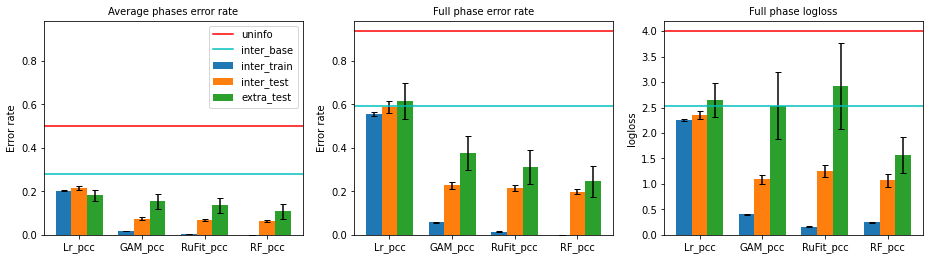

In [69]:
colors = ['r', 'c', 'm', 'y', 'b']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, sharex=True)
fig.set_size_inches(cm2inch(40, 10))

width = 0.25
fontsize = 10
ind = np.arange(len(interpolation))

ax1.bar(ind-width, interpolation[f'mean_train_hamming loss'], width=width, label='inter_train', 
        yerr=interpolation[f'std_train_hamming loss']/30**0.5, capsize=3.0)
ax1.bar(ind, interpolation[f'mean_test_hamming loss'], width=width, label='inter_test',
        yerr=interpolation[f'std_test_hamming loss']/30**0.5, capsize=3.0)
ax1.bar(ind+width, extrapolation[f'mean_test_hamming loss'], width=width, label='extra_test',
        yerr=extrapolation[f'std_test_hamming loss']/28**0.5, capsize=3.0)

ax1.set_title('Average phases error rate', fontsize=fontsize)
ax1.set_xticks(ind)
ax1.set_ylabel('Error rate', fontsize=fontsize)
ax1.set_xticklabels(interpolation.index, fontsize=fontsize)

# add base line
avg_error_base = [inter_uninfo_hamming_loss, unreal_inter_hamming_loss]
avg_error_name = ['uninfo', 'inter_base']
for i in range(len(avg_error_base)):
    ax1.axhline(y=avg_error_base[i], color=colors[i], linestyle='-', label=avg_error_name[i])

ax1.legend(fontsize=fontsize)
ax1.sharey(ax2) ########### here to share the y axis

ax2.bar(ind-width, interpolation[f'mean_train_error'], width=width, label='inter_train', 
        yerr=interpolation[f'std_train_error']/30**0.5, capsize=3.0)
ax2.bar(ind, interpolation[f'mean_test_error'], width=width, label='inter_test',
        yerr=interpolation[f'std_test_error']/30**0.5, capsize=3.0)
ax2.bar(ind+width, extrapolation[f'mean_test_error'], width=width, label='extra_test',
        yerr=extrapolation[f'std_test_error']/28**0.5, capsize=3.0)

# add base line
inter_error_base = [inter_full_uninfo_error, unreal_inter_full_info_error]
inter_error_name = ['uninfo', 'inter_base']
for i in range(len(inter_error_base)):
    ax2.axhline(y=inter_error_base[i], color=colors[i], linestyle='-', label=inter_error_name[i])

ax2.set_title('Full phase error rate', fontsize=fontsize)
ax2.set_xticks(ind)
ax2.set_xticklabels(extrapolation.index, fontsize=fontsize)
ax2.set_ylabel('Error rate', fontsize=fontsize)

ax3.bar(ind-width, interpolation[f'mean_train_log loss'], width=width, label='inter_train', 
        yerr=interpolation[f'std_train_log loss']/30**0.5, capsize=3.0)
ax3.bar(ind, interpolation[f'mean_test_log loss'], width=width, label='inter_test',
        yerr=interpolation[f'std_test_log loss']/30**0.5, capsize=3.0)
ax3.bar(ind+width, extrapolation[f'mean_test_log loss'], width=width, label='extra_test',
        yerr=extrapolation[f'std_test_log loss']/28**0.5, capsize=3.0)

full_loss_base = [4, unreal_inter_full_info_loss]
full_loss_name = ['uninfo', 'inter_base']
for i in range(len(full_loss_base)):
    ax3.axhline(y=full_loss_base[i], color=colors[i], linestyle='-', label=full_loss_name[i])

ax3.set_title('Full phase logloss', fontsize=fontsize)
ax3.set_xticks(ind)
ax3.set_xticklabels(extrapolation.index, fontsize=fontsize)
ax3.set_ylabel('logloss', fontsize=fontsize)

plt.show()

In [66]:
import os
from common import OUTPUTPATH

plt.savefig(os.path.join(OUTPUTPATH, 'Performance_plot.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()

<Figure size 432x288 with 0 Axes>